In [20]:
from collections import OrderedDict

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision.models._utils import IntermediateLayerGetter
from typing import Dict, List

import sys
sys.path.append('../')
from util.misc import NestedTensor, is_main_process


from models.position_encoding import build_position_encoding
from models.backbone import BackboneBase


import argparse
import datetime
import json
from models import build_model
from datasets import build_dataset
from datasets import get_coco_api_from_dataset
import util.misc as utils
from engine import evaluate, train_one_epoch
from models import build_model



from feed import LbpDataset

import pandas as pd
import numpy as np


In [21]:
from main import get_args_parser
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
parser.add_argument('--workers', default=8, type=int)
args = parser.parse_args(args=[])
args.coco_path = '../COCO/'
args.batch_size = 6
args.resume = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth'
args.distributed = False
args.output_dir = '../trained_models/'
args.num_class = 1 # remove back ground task, only real task
args.epochs = 100
# args.lr_drop = 50
args.lr = 0.0001
args.device = 'cuda:0'

In [22]:
from feed import CLASS_MAPPER, get_train_test_list, train_transforms, val_transforms
df = pd.read_csv('../../data/df.csv')
df.label = df.label.apply(lambda x : CLASS_MAPPER[str(x)])
print(df.shape)
# Data loading code#
train_list, test_list = get_train_test_list(df)
train_dataset = LbpDataset(train_list, default_path='/home/beomgon/Dataset/scl/', transform=train_transforms)
test_dataset = LbpDataset(test_list, default_path='/home/beomgon/Dataset/scl/', transform=val_transforms)  

(9735, 12)


../feed.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['xmax'] = df.apply(lambda x : x['xmin'] + x['w'], axis=1)
../feed.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ymax'] = df.apply(lambda x : x['ymin'] + x['h'], axis=1)
../feed.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

total 7176 train 5382 test 1794


Exception ignored in: <function tqdm.__del__ at 0x7fe7c644c290>
Traceback (most recent call last):
  File "/home/beomgon/anaconda3/envs/detr/lib/python3.7/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/beomgon/anaconda3/envs/detr/lib/python3.7/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


5382
1794


In [23]:
test_sampler = torch.utils.data.SequentialSampler(test_dataset)
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size,
#     sampler=test_sampler, 
    shuffle=True,
    num_workers=args.workers,
    collate_fn=utils.collate_fn)


In [92]:
images, targets = next(iter(data_loader_test))
targets

({'boxes': tensor([[0.3074, 0.3469, 0.0952, 0.1675]]),
  'labels': tensor([1]),
  'image_id': tensor([3605]),
  'area': tensor([66885.]),
  'iscrowd': tensor([0]),
  'orig_size': tensor([1024, 1024]),
  'size': tensor([1024, 1024])},
 {'boxes': tensor([[0.3313, 0.5835, 0.0845, 0.1094]]),
  'labels': tensor([1]),
  'image_id': tensor([1142]),
  'area': tensor([38752.]),
  'iscrowd': tensor([0]),
  'orig_size': tensor([1024, 1024]),
  'size': tensor([1024, 1024])},
 {'boxes': tensor([[0.6697, 0.5764, 0.0483, 0.0483]]),
  'labels': tensor([1]),
  'image_id': tensor([7321]),
  'area': tensor([9801.]),
  'iscrowd': tensor([0]),
  'orig_size': tensor([1024, 1024]),
  'size': tensor([1024, 1024])},
 {'boxes': tensor([[0.4766, 0.6440, 0.0566, 0.0615],
          [0.9114, 0.1011, 0.0630, 0.0732]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([2201]),
  'area': tensor([14616., 19350.]),
  'iscrowd': tensor([0, 0]),
  'orig_size': tensor([1024, 1024]),
  'size': tensor([1024, 1024])},
 {'boxe

In [25]:
device = torch.device(args.device)
model, criterion, postprocessors = build_model(args)

model_without_ddp = model
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)  

number of params: 39847265


In [26]:
class_embed = nn.Linear(in_features=256, out_features=args.num_class + 1, bias=True)         
model_without_ddp.class_embed = nn.ModuleList([class_embed for _ in range(6)])

model_without_ddp.to(device)
print('model is loaded to gpu')

model is loaded to gpu


In [27]:
model_without_ddp.class_embed

ModuleList(
  (0): Linear(in_features=256, out_features=2, bias=True)
  (1): Linear(in_features=256, out_features=2, bias=True)
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Linear(in_features=256, out_features=2, bias=True)
  (4): Linear(in_features=256, out_features=2, bias=True)
  (5): Linear(in_features=256, out_features=2, bias=True)
)

In [67]:
# checkpoint = torch.load('./checkpoint.pt', map_location=args.device)
checkpoint = torch.load('../trained_models/model_95.pth', map_location=args.device)
model_without_ddp.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

RED_COLOR = (255, 0, 0) # Red
BLUE_COLOR = (0, 0, 255) # Blue
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, boxes, color=RED_COLOR, thickness=3):
    """Visualizes a single bounding box on the image"""
    bbox = boxes[:4]
    if len(boxes) ==5 and boxes[4] ==1 :
        color = (0, 255, 0)
    x_min, y_min, x_max, y_max = list(map(int, bbox))
#     print(bbox)
#     x_min, y_min, x_max, y_max = list(map(round, bbox))
#     print((int(x_min), int(y_min)), (int(x_max), int(y_max)))

    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), color=color, thickness=thickness)
    return img

def visualize(image, g_boxes, p_boxes=[]):
    img = image.copy()
    print(img.shape)
#     img = image.clone().detach()
    for bbox in (g_boxes):
#         print(bbox)
        img = visualize_bbox(img, bbox)
    for bbox in (p_boxes):
#         print(bbox)
        img = visualize_bbox(img, bbox, color=BLUE_COLOR, thickness=5)    
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(img)
    
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size=(1024,1024)):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32, device='cuda:0')
    return b

In [93]:
# @torch.no_grad()
with torch.no_grad() :
    model.eval()
    iou_types = tuple(k for k in ('segm', 'bbox') if k in postprocessors.keys())
    
    samples, targets = next(iter(data_loader_test))
    samples = samples.to(device)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(samples)
    

In [109]:
# keep only predictions with 0.7+ confidence
BATCH_NUM = 2
probas = outputs['pred_logits'].softmax(-1)[BATCH_NUM, :, 1:]
keep = (probas.max(-1).values > 0.7)

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][BATCH_NUM, keep])
# bboxes_scaled

In [110]:
# bboxes_scaled[0:2].numpy()
# # probas[0]

In [111]:
g_boxes = targets[BATCH_NUM]['boxes'].cuda()
g_boxes = rescale_bboxes(g_boxes)
g_boxes.cpu().numpy()

array([[805. , 398. , 892.5, 552.5]], dtype=float32)

In [112]:
import cv2
path = df[df['ID'] == targets[BATCH_NUM]['image_id'].item()].file_name.unique()[0]
img = cv2.imread('/home/beomgon/Dataset/scl/' + path)
img = cv2.resize(img, (1024, 1024))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(1024, 1024, 3)

(1024, 1024, 3)


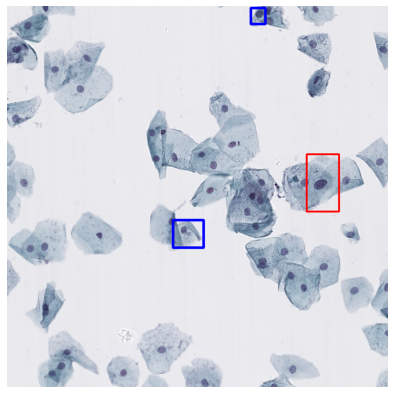

In [113]:
visualize(img, g_boxes.cpu().numpy(), bboxes_scaled[0:2].cpu().numpy())